# COMP551: Project 4

In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [0]:
# Load the Drive helper and mount for colab
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

In [37]:

training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.491399689874, 0.482158419622, 0.446530924224), (0.247032237587, 0.243485133253, 0.261587846975))
                   ]))
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.491399689874, 0.482158419622, 0.446530924224), (0.247032237587, 0.243485133253, 0.261587846975))
                   ]))

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size =100, shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.squeezenet1_0(pretrained = True)
#import OrderedDicted to corectly align the network layers


In [39]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [0]:
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs

classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(1)
)
#replace the model's classifier with this new classifier 
model.classifier = classifier
model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), 10)


In [41]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    current_correct_5=0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)#The most likelihood
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)#Top-5 prediction
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        for i in range(100):
            for j in preds_5[i]:
                current_correct_5+=torch.sum(y_train.data[i]==j)
        #print(output,preds,preds_5)
        #check if the training is correct: 
        #print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100 # Top 1 accuracy
    epoch_acc_5 = current_correct_5.double()/len(loader)/100 #Top 5 accuracy
        
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_correct_5 = 0 #Top 5 accuracy
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        _, preds_5=torch.topk(output, 5, largest=True, sorted=True)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
        for i in range(100):
            for j in preds_5[i]:
                valid_correct_5+=torch.sum(y_valid.data[i]==j)
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    epoch_acc_5 = valid_correct_5.double() / len(loader)/100
    
    return epoch_loss, epoch_acc,epoch_acc_5

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [47]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
train_acc_5 =[]
valid_losses=[]
valid_acc =[]
valid_acc_5 =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 10
epoch = 0
import time
start=time.time()
for e in range(epochs):
    start_train = time.time()
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc, epoch_train_acc_5 = train(model,trainloader, criteria, 1)
        #epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        train_acc_5.append(epoch_train_acc_5)
    print("Epoch: {} Train Loss : {:.4f}  Top1 Accuracy: {:.4f}  Top5 Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc,epoch_train_acc_5))
    end_train=time.time()
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc,epoch_val_acc_5 = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
        valid_acc_5.append(epoch_val_acc_5)
    print("Epoch: {} Validation Loss : {:.4f}  Top 1 Validation Accuracy {:.4f} Top5 Validation Accuracy: {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc,epoch_val_acc_5))
    end_valid = time.time()
    print("Training time for Epoch {}: {:.4f}s".format(epoch,end_train-start_train))
    print("Validation time for Epoch {}: {:.4f}s".format(epoch,end_valid-end_train))
end=time.time()
print("Total time for training and validation: {:.4f}s".format(end-start))

1
Epoch: 1 Train Loss : 179.2313  Top1 Accuracy: 0.3541  Top5 Accuracy: 0.7919
Epoch: 1 Validation Loss : 118.3078  Top 1 Validation Accuracy 0.5863 Top5 Validation Accuracy: 0.9497
Training time for Epoch 1: 38.7705s
Validation time for Epoch 1: 6.4540s
2
Epoch: 2 Train Loss : 107.8382  Top1 Accuracy: 0.6396  Top5 Accuracy: 0.9543
Epoch: 2 Validation Loss : 91.4238  Top 1 Validation Accuracy 0.6870 Top5 Validation Accuracy: 0.9679
Training time for Epoch 2: 39.4843s
Validation time for Epoch 2: 6.3802s
3
Epoch: 3 Train Loss : 91.1460  Top1 Accuracy: 0.6993  Top5 Accuracy: 0.9658
Epoch: 3 Validation Loss : 92.1687  Top 1 Validation Accuracy 0.6909 Top5 Validation Accuracy: 0.9683
Training time for Epoch 3: 39.5703s
Validation time for Epoch 3: 6.4581s
4
Epoch: 4 Train Loss : 83.1946  Top1 Accuracy: 0.7256  Top5 Accuracy: 0.9713
Epoch: 4 Validation Loss : 78.8867  Top 1 Validation Accuracy 0.7342 Top5 Validation Accuracy: 0.9742
Training time for Epoch 4: 39.7412s
Validation time for Ep

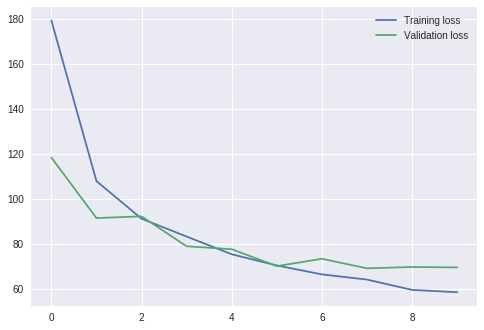

In [48]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

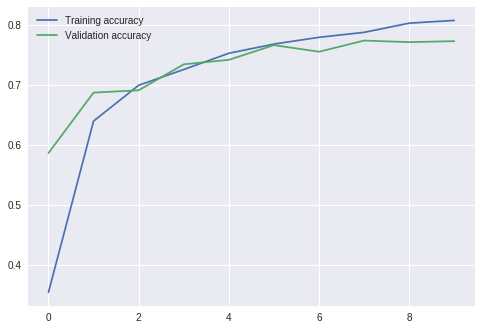

In [49]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [50]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  179.231257
  1       2   train  107.838198
  2       3   train   91.145969
  3       4   train   83.194554
  4       5   train   75.334057
  5       6   train   70.362480
  6       7   train   66.393589
  7       8   train   64.084575
  8       9   train   59.499211
  9      10   train   58.476056
  10      1   valid  118.307825
  11      2   valid   91.423791
  12      3   valid   92.168744
  13      4   valid   78.886697
  14      5   valid   77.573253
  15      6   valid   70.074277
  16      7   valid   73.325413
  17      8   valid   69.080729
  18      9   valid   69.679547
  19     10   valid   69.503882,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector003: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})